<a href="https://colab.research.google.com/github/CIA-Oceanix/DLCourse_MOi_2022/blob/main/notebooks/PytorchLightninging_MNIST_classification_MLP_with_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Pytorch Lightning for training a MLP on Fashion-MNIST 


---



In [ ]:
pip install pytorch_lightning==1.6.5 -q

     |████████████████████████████████| 585 kB 6.6 MB/s 


In [ ]:
import pytorch_lightning as pl
import pandas as pd
import matplotlib.pyplot as plt

## 1- Data management (Same as yesterday) <a class="anchor" id="section_1"></a>

Start with these lines of code to automatically download the Fashion-MNIST dataset.

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()

#train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
#test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)


#### **Dataloader creation** - Check data loader documentation ([documentation](https://pytorch.org/docs/stable/data.html)) for training, validation and test sets. <a class="anchor" id="question_1_2"></a>

In [ ]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 20
valid_size = 0.2
train_size = 0.3

def create_data_loaders(batch_size, valid_size, train_data, test_data): # FUNCTION TO BE COMPLETED

  total_train = len(train_data)
  num_val = int(total_train * valid_size)
  num_train = total_train - num_val

  tr_data, val_data = torch.utils.data.random_split(train_data, [num_train, num_val])
  train_loader = torch.utils.data.DataLoader(tr_data, batch_size = batch_size)
  valid_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

  return train_loader, valid_loader, test_loader

In [ ]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data) # TO DO

#### **MNIST samples** - Visualize some images from the training set with corresponding ground truth labels. <a class="anchor" id="question_1_3"></a>

## 2-  Multi-Layer Perceptron using **Pytorch Lightning** (LitMLP) <a class="anchor" id="section_2"></a>

Below we transpose the MLP training seen yesterday using pytorch lightning with the following step:


---



Steps:
- [ ] **TODO 1: Integrate training and validation logic in the Lightning Module**
  - [ ] change module class
  - [ ] implement training_step and validation_step methods
  - [ ] implement configure_optimizer method
  - [ ] launch training using a Trainer object
- [ ] **TODO 2: Train on GPU**
  - [ ] find the correct parameter in the Trainer class
- [ ] **TODO 3: Track metrics during training**
  - [ ] instantiate a CsvLogger logger and pass it to the trainer
  - [ ] log the metrics you want to track in the training and validation steps
  - [ ] plot the evolution of the metrics at the end of the training (`pandas.read_csv(...).(...).plot()`)
- [ ] **TODO 4: Add model checkpointing**
  - [ ] instantiate a ModelCheckpointCallback
  - [ ] Pass the callback to the trainer
  - [ ] Load the best checkpoint state in the model at the end of the training
- [ ] **TODO 5 (Bonus): Integrate diagnostic to the Lightning Module**
  - [ ] implement test_step method that compute the necessary output for each batch
  - [ ] implement test_epoch_end that compute aggregated metrics and diagnostics
  - [ ] save outputs as files OR as attributes of the Lightning Module

  
  

#### **MLP architecture** - Define a MPL architecture with (at least) 2 fully-connected as well as dropout layers. <a class="anchor" id="question_2_1"></a>

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LitMLP(pl.LightningModule): # TODO 1
    def __init__(self): # FUNCTION TO BE COMPLETED
        super().__init__()
        hidden_1, hidden_2 = 512, 256
        self.fc1 = nn.Linear(28*28, hidden_1)
        self.fc2 = nn.Linear(hidden_1,hidden_2)
        self.fc3 = nn.Linear(hidden_2,10)
        self.dropout = nn.Dropout(0.2)

        self.criterion = nn.CrossEntropyLoss() ## TODO 1

        self.test_data = None ## TODO 5


        
    def forward(self,x): 
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
    def training_step(self, batch, batch_idx): ## TODO 1
        data, label = batch
        output = self(data)
        loss = self.criterion(output, label)
        self.log('train_loss', loss) ## TODO 3
        return loss
    
    def validation_step(self, batch, batch_idx): ## TODO 1
        data, label = batch
        output = self(data)
        loss = self.criterion(output, label)
        self.log('val_loss', loss) ## TODO 3
        return loss
  
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(),lr = 0.01) ## TODO 1

    def test_step(self, batch, batch_idx): ## TODO 5
        data, label = batch
        output = self(data)
        loss = self.criterion(output, label)
        self.log('test_loss', loss)

        preds = torch.max(output.cpu(), 1)[1]
        return label.cpu(), preds 

      
    def test_epoch_end(self, test_step_outputs): ## TODO 5
        list_of_labels, list_of_preds = zip(*test_step_outputs)
        labels, preds = torch.cat(list_of_labels),  torch.cat(list_of_preds)
        

        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        correct = np.squeeze(preds.eq(labels.data.view_as(preds)))
        for i in range(len(labels)):
            digit = labels.data[i]
            class_correct[digit] += correct[i].item()
            class_total[digit] += 1

        for i in range(10):
            print(
                'test accuracy of %s: %2d%% (%2d/%2d)' 
                % (i, 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i]))
            )

        print(
            '\ntest accuracy (overall): %2.2f%% (%2d/%2d)'
             % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total))
        )

        self.test_data = labels, preds



 **TODO 1: Integrate training and validation logic in the Lightning Module**
 

In [ ]:
model = LitMLP()
trainer = pl.Trainer()
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

**TODO 2: Train on GPU**

In [ ]:
model = LitMLP()
trainer = pl.Trainer(
    gpus=1, # TODO 2
    max_epochs=15,
)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

**TODO 3: Track metrics during training**

In [ ]:
model = LitMLP()
logger = pl.loggers.CSVLogger('logs', name='mlp_mnist') # TODO 3
trainer = pl.Trainer(
    gpus=1, max_epochs=15,
    logger=logger # TODO 3
  )
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

## Plot metrics
(
    pd.read_csv(f'{logger.log_dir}/metrics.csv') .groupby('epoch').mean()
    [['train_loss', 'val_loss']].plot(grid=True)
)

**TODO 4: Add model checkpointing**

In [ ]:
# TODO 4
model = LitMLP()
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss') # TODO 4
logger = pl.loggers.CSVLogger('logs', name='mlp_mnist') 
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=10,
    callbacks=[model_checkpoint], # TODO 4
    logger=logger
  )

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
print(f"""
    Best model saved at {model_checkpoint.best_model_path}
    With validation loss {model_checkpoint.best_model_score}
""")

# Loading best model
best_mlp = LitMLP.load_from_checkpoint(model_checkpoint.best_model_path)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | fc1       | Linear           | 401 K 
1 | fc2       | Linear           | 131 K 
2 | fc3       | Lin

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 2400: 'val_loss' reached 0.38847 (best 0.38847), saving model to 'logs/mlp_mnist/version_0/checkpoints/epoch=0-step=2400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 4800: 'val_loss' reached 0.29026 (best 0.29026), saving model to 'logs/mlp_mnist/version_0/checkpoints/epoch=1-step=4800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 7200: 'val_loss' reached 0.23984 (best 0.23984), saving model to 'logs/mlp_mnist/version_0/checkpoints/epoch=2-step=7200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 9600: 'val_loss' reached 0.20092 (best 0.20092), saving model to 'logs/mlp_mnist/version_0/checkpoints/epoch=3-step=9600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 12000: 'val_loss' reached 0.17350 (best 0.17350), saving model to 'logs/mlp_mnist/version_0/checkpoints/epoch=4-step=12000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 14400: 'val_loss' reached 0.15390 (best 0.15390), saving model to 'logs/mlp_mnist/version_0/checkpoints/epoch=5-step=14400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 16800: 'val_loss' reached 0.13809 (best 0.13809), saving model to 'logs/mlp_mnist/version_0/checkpoints/epoch=6-step=16800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 19200: 'val_loss' reached 0.12537 (best 0.12537), saving model to 'logs/mlp_mnist/version_0/checkpoints/epoch=7-step=19200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 21600: 'val_loss' reached 0.11632 (best 0.11632), saving model to 'logs/mlp_mnist/version_0/checkpoints/epoch=8-step=21600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 24000: 'val_loss' reached 0.10797 (best 0.10797), saving model to 'logs/mlp_mnist/version_0/checkpoints/epoch=9-step=24000.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


**TODO 5 (Bonus): Integrate diagnostic to the Lightning Module**

*Testing the trained MLP model * - Test the best model on (unseen) test data and evaluate it’s performance in terms of overall and per-class accuracy scores.



In [ ]:
best_mlp = LitMLP.load_from_checkpoint('logs/mlp_mnist/version_0/checkpoints/epoch=9-step=24000.ckpt')
trainer = pl.Trainer(gpus=1) 
trainer.test(best_mlp, dataloaders=test_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:95: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

test accuracy of 0: 98% (966/980)
test accuracy of 1: 99% (1124/1135)
test accuracy of 2: 97% (1002/1032)
test accuracy of 3: 96% (977/1010)
test accuracy of 4: 97% (959/982)
test accuracy of 5: 96% (860/892)
test accuracy of 6: 97% (934/958)
test accuracy of 7: 96% (991/1028)
test accuracy of 8: 95% (926/974)
test accuracy of 9: 94% (956/1009)

test accuracy (overall): 96.95% (9695/10000)
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.10026112198829651
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.10026112198829651}]

#### **Uncorrect classifications** - Visualize some incorrect predictions by displaying test images and labels in the format: "predicted (ground-truth)". <a class="anchor" id="question_2_5"></a>

In [ ]:
targets, preds_1 = best_mlp.test_data

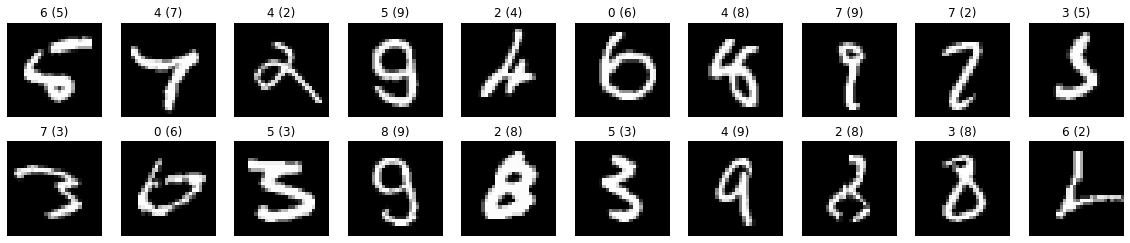

In [ ]:
index = np.where(preds_1 - targets != 0)[0]
test_set_array = test_data.data.numpy()
plt.figure(figsize=(20, 4))
for i in range(20):
  plt.subplot(2, 10, i + 1)
  plt.axis('off')
  plt.imshow(test_set_array[index[i],:,:], cmap='gray')
  plt.title("{} ({})".format(preds_1[index[i]], targets[index[i]]))
plt.show()